In [1]:
# Necessary imports
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

import warnings; warnings.filterwarnings("ignore")
from tqdm import tqdm

In [2]:
train = pd.read_csv("data/train.csv", parse_dates=['Datetime']); display(train.head(3))
test = pd.read_csv("data/test.csv", parse_dates=['Datetime']); display(test.head(3))

,ID,Datetime,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Offset_fault
0,ID_QF0ZTQJ2SF5Q,2021-11-03 04:06:31,52.58,49.52,17.4,96.0,0
1,ID_4GTK689CNX5S,2021-11-08 18:43:23,35.25,33.40,25.0,75.0,0
2,ID_DL7VVKW9U7XQ,2021-11-07 09:50:33,19.18,23.50,24.9,75.0,0


,ID,Datetime,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity
0,ID_STL3V9B2OU12,2022-01-28 08:49:41,90.75,114.78,22.2,56.0
1,ID_U2EKAY4SGA94,2022-02-16 21:30:17,56.03,52.18,NaN,NaN
2,ID_UJFLEWQR0U4N,2022-01-24 17:57:18,387.35,346.73,28.1,63.0


In [3]:
# data prep
train['log_sensor1'] = np.log(train['Sensor1_PM2.5']).replace([np.inf, -np.inf], 0)
train = train[train.log_sensor1 >= 0]
train['log_sensor2'] = np.log(train['Sensor2_PM2.5']).replace([np.inf, -np.inf], 0)
train = train[train.log_sensor2 >= -.5]

# log transforms for test
test['log_sensor1'] = np.log(test['Sensor1_PM2.5']).replace([np.inf, -np.inf], 0)
test['log_sensor2'] = np.log(test['Sensor2_PM2.5']).replace([np.inf, -np.inf], 0)

In [4]:
# combine datasets
data = pd.concat([train, test])

In [5]:
# feature engineering
def feat_eng(df):
    
    # sort by Datetime
    df = df.sort_values('Datetime').reset_index(drop=True)
    
    df['year'] = df.Datetime.dt.year
    df['month'] = df.Datetime.dt.month
    df['dayof_month'] = df.Datetime.dt.day
    df['dayof_week'] = df.Datetime.dt.dayofweek
    df['weekend'] = df.Datetime.dt.weekday.apply(lambda x: 0 if x<5 else 1)
    df['hour'] = df.Datetime.dt.hour
    df['minute'] = df.Datetime.dt.minute
    df['second'] = df.Datetime.dt.second
    
    df['second_diff'] = df.second.diff().fillna(pd.to_datetime(0).second)
    df['sensor1_diff'] = df['Sensor1_PM2.5'].diff().fillna(0)
    df['sensor2_diff'] = df['Sensor2_PM2.5'].diff().fillna(0)
    df['temp_diff'] = df.Temperature.diff().fillna(0)
    df['humid_diff'] = df.Relative_Humidity.diff().fillna(0)
    
    df['sensor_diff'] = df['Sensor1_PM2.5'] - df['Sensor2_PM2.5']
    
    # binning
    df['temp_bins'] = pd.cut(df.Temperature, bins=10, labels=False)
    df['humid_bins'] = pd.cut(df.Relative_Humidity, bins=5, labels=False)
    
    # more features
    df['sensor_avg'] = (df['Sensor1_PM2.5'] + df['Sensor2_PM2.5']) / 2
    # dewpoint
    df['dewpoint'] = df.Temperature - ((1 - df.Relative_Humidity)/5)
        
    # combination features
    df['humixtemp'] = df.Relative_Humidity * df.Temperature
    df['humixtemp2'] = (df.Relative_Humidity*100) / df.Temperature
    
    # sin/cos on time features
    for col in ['year', 'month', 'dayof_month', 'dayof_week', 'hour', 'minute', 'second']:
        df[f'sin_{col}'] = np.sin(df[col]).replace([np.inf, -np.inf, np.nan], 0)
        df[f'cos_{col}'] = np.cos(df[col]).replace([np.inf, -np.inf, np.nan], 0)
        df[f'tan_{col}'] = np.tan(df[col]).replace([np.inf, -np.inf, np.nan], 0)
    
    # feature interactions
    categorical_features = ['year', 'month', 'hour', 'temp_bins', 'humid_bins']
    continuous_features = ['Sensor1_PM2.5', 'Sensor2_PM2.5', 'sensor_avg', 'sensor_diff']
    for cat_feat in categorical_features:
        for cont_feat in continuous_features:
            df[f'{cat_feat}_interact_{cont_feat}_mean'] = df[cat_feat].map(df.groupby(cat_feat)[cont_feat].mean().to_dict())
    
    return df


In [6]:
data = feat_eng(data)

In [7]:
# separate datasets
train = data[data.Offset_fault.notnull()]
test = data[data.Offset_fault.isna()]; test.drop('Offset_fault', 1, inplace=True)
del data

In [8]:
train

,ID,Datetime,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Offset_fault,log_sensor1,log_sensor2,year,month,dayof_month,dayof_week,weekend,hour,minute,second,second_diff,sensor1_diff,sensor2_diff,temp_diff,humid_diff,sensor_diff,temp_bins,humid_bins,sensor_avg,dewpoint,humixtemp,humixtemp2,sin_year,cos_year,tan_year,sin_month,cos_month,tan_month,sin_dayof_month,cos_dayof_month,tan_dayof_month,sin_dayof_week,cos_dayof_week,tan_dayof_week,sin_hour,cos_hour,tan_hour,sin_minute,cos_minute,tan_minute,sin_second,cos_second,tan_second,year_interact_Sensor1_PM2.5_mean,year_interact_Sensor2_PM2.5_mean,year_interact_sensor_avg_mean,year_interact_sensor_diff_mean,month_interact_Sensor1_PM2.5_mean,month_interact_Sensor2_PM2.5_mean,month_interact_sensor_avg_mean,month_interact_sensor_diff_mean,hour_interact_Sensor1_PM2.5_mean,hour_interact_Sensor2_PM2.5_mean,hour_interact_sensor_avg_mean,hour_interact_sensor_diff_mean,temp_bins_interact_Sensor1_PM2.5_mean,temp_bins_interact_Sensor2_PM2.5_mean,temp_bins_interact_sensor_avg_mean,temp_bins_interact_sensor_diff_mean,humid_bins_interact_Sensor1_PM2.5_mean,humid_bins_interact_Sensor2_PM2.5_mean,humid_bins_interact_sensor_avg_mean,humid_bins_interact_sensor_diff_mean
0,ID_37STUCVVPZKP,2021-10-15 16:00:31,9.17,9.28,29.9,53.0,0.0,2.215937,2.227862,2021,10,15,4,0,16,0,31,0.0,0.00,0.00,0.0,0.0,-0.11,7.0,1.0,9.225,40.3,1584.7,177.257525,-0.816847,-0.576854,1.416036,-0.544021,-0.839072,0.648361,0.650288,-0.759688,-0.855993,-0.756802,-0.653644,1.157821,-0.287903,-0.957659,0.300632,0.000000,1.000000,0.000000,-0.404038,0.914742,-0.441696,38.373179,35.636425,37.004802,2.736755,38.557775,35.415364,36.986570,3.142411,24.278581,23.595235,23.936908,0.683346,23.394365,22.282515,22.838440,1.111851,29.454523,28.398544,28.926533,1.055979
1,ID_YZZUOMF0TQIF,2021-10-15 16:00:34,9.93,11.25,29.9,53.0,0.0,2.295560,2.420368,2021,10,15,4,0,16,0,34,3.0,0.76,1.97,0.0,0.0,-1.32,7.0,1.0,10.590,40.3,1584.7,177.257525,-0.816847,-0.576854,1.416036,-0.544021,-0.839072,0.648361,0.650288,-0.759688,-0.855993,-0.756802,-0.653644,1.157821,-0.287903,-0.957659,0.300632,0.000000,1.000000,0.000000,0.529083,-0.848570,-0.623499,38.373179,35.636425,37.004802,2.736755,38.557775,35.415364,36.986570,3.142411,24.278581,23.595235,23.936908,0.683346,23.394365,22.282515,22.838440,1.111851,29.454523,28.398544,28.926533,1.055979
2,ID_UF68QLIPG3LE,2021-10-15 16:01:01,6.53,3.15,29.9,53.0,1.0,1.876407,1.147402,2021,10,15,4,0,16,1,1,-33.0,-3.40,-8.10,0.0,0.0,3.38,7.0,1.0,4.840,40.3,1584.7,177.257525,-0.816847,-0.576854,1.416036,-0.544021,-0.839072,0.648361,0.650288,-0.759688,-0.855993,-0.756802,-0.653644,1.157821,-0.287903,-0.957659,0.300632,0.841471,0.540302,1.557408,0.841471,0.540302,1.557408,38.373179,35.636425,37.004802,2.736755,38.557775,35.415364,36.986570,3.142411,24.278581,23.595235,23.936908,0.683346,23.394365,22.282515,22.838440,1.111851,29.454523,28.398544,28.926533,1.055979
3,ID_KKCO4VATOSWB,2021-10-15 16:01:54,8.30,8.35,29.9,53.0,0.0,2.116256,2.122262,2021,10,15,4,0,16,1,54,53.0,1.77,5.20,0.0,0.0,-0.05,7.0,1.0,8.325,40.3,1584.7,177.257525,-0.816847,-0.576854,1.416036,-0.544021,-0.839072,0.648361,0.650288,-0.759688,-0.855993,-0.756802,-0.653644,1.157821,-0.287903,-0.957659,0.300632,0.841471,0.540302,1.557408,-0.558789,-0.829310,0.673800,38.373179,35.636425,37.004802,2.736755,38.557775,35.415364,36.986570,3.142411,24.278581,23.595235,23.936908,0.683346,23.394365,22.282515,22.838440,1.111851,29.454523,28.398544,28.926533,1.055979
4,ID_8YNKABZP11SS,2021-10-15 16:02:06,6.87,9.57,29.9,53.0,0.0,1.927164,2.258633,2021,10,15,4,0,16,2,6,-48.0,-1.43,1.22,0.0,0.0,-2.70,7.0,1.0,8.220,40.3,1584.7,177.257525,-0.816847,-0.576854,1.416036,-0.544021,-0.839072,0.648361,0.650288,-0.759688,-0.855993,-0.756802,-0.653644,1.157821,-0.287903,-0.957659,0.300632,0.909297,-0.416147,-2.185040,-0.279415,0.960170,-0.291006,38.373179,35.636425,37.004802,2.736755,38.557775,35.415364,36.986570,3.142411,24.278581,23.595235,23.936908,0.683346,23.394365,22.282515,22.

# 2 tasks:
- train_notnull VS test_notnull
- (train + test_notnull) VS test_null (without Temperature and Relative_Humidity columns)

In [9]:
train_notnull = train.dropna().reset_index(drop=True)
test_notnull = test.dropna().reset_index(drop=True)

test_null = test[~test.ID.isin(test_notnull.ID)].reset_index(drop=True)

## 1. train_notnull VS test_notnull
Test models:

In [10]:
feat_cols = test.select_dtypes(np.number).columns
X, y = train_notnull[feat_cols], train_notnull.Offset_fault
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)

Cross Validation:

In [15]:
list(pd.DataFrame(pd.DataFrame(y_train).Offset_fault.value_counts()*100 / len(y_train)).to_dict().values())[0]

{0.0: 63.05858008572695, 1.0: 36.94141991427305}

In [18]:
#oofs_df_rf = []
preds_df_rf = []
accuracy = []

NFOLDS = 10
fold = KFold(n_splits=NFOLDS)

for train_index, test_index in fold.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    #model = RandomForestClassifier(class_weight=list(pd.DataFrame(pd.DataFrame(y_train).label.value_counts()*100 / len(y_train)).to_dict().values())[0])
    #model = CatBoostClassifier(eval_metric="AUC", verbose=False,
     #                          class_weights=list(pd.DataFrame(pd.DataFrame(y_train).Offset_fault.value_counts()*100 / len(y_train)).to_dict().values())[0])
    model = XGBClassifier(objective='binary:logistic', eval_metric='logloss')
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    #oofs_df_rf[test_index] = preds
    #oofs_df_rf.append(preds)
    acc = accuracy_score(y_test, preds)
    print("ACC : ", acc); print("="*40, "\n", classification_report(y_test, preds))
    accuracy.append(acc)
    
    p2 = model.predict(test_notnull[feat_cols])
    preds_df_rf.append(p2)
    
print(f"\nMean ACC: {np.mean(accuracy)}")

ACC :  0.9972754862739688
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     18645
         1.0       1.00      1.00      1.00     10351

    accuracy                           1.00     28996
   macro avg       1.00      1.00      1.00     28996
weighted avg       1.00      1.00      1.00     28996

ACC :  0.9929645468340461
               precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     18314
         1.0       0.99      0.99      0.99     10682

    accuracy                           0.99     28996
   macro avg       0.99      0.99      0.99     28996
weighted avg       0.99      0.99      0.99     28996

ACC :  0.9941716098772244
               precision    recall  f1-score   support

         0.0       1.00      0.99      1.00     18513
         1.0       0.99      1.00      0.99     10483

    accuracy                           0.99     28996
   macro avg       0.99      0.99      0.99    

In [19]:
np.array(preds_df_rf).shape

(10, 39271)

In [20]:
df = pd.DataFrame(preds_df_rf).T
df

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
39266,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39269,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
# take most occurring observation from every row
import scipy.stats

df['label'] = np.nan

for idx in tqdm(df.index):
    # most occuring
    most = scipy.stats.mode(list(df.iloc[idx]))[0][0]
    df.loc[idx, 'label'] = most
    
df

100%|███████████████████████████████████| 39271/39271 [00:34<00:00, 1124.95it/s]


,0,1,2,3,4,5,6,7,8,9,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
39266,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39269,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
sub_notnull = pd.DataFrame({
    'ID': test_notnull.ID.values,
    'Offset_fault': df.label
})
sub_notnull

,ID,Offset_fault
0,ID_H9H3ENR9M13N,0.0
1,ID_JLD6XFEW7EAM,0.0
2,ID_OQ01HEDYRZEU,1.0
3,ID_NHK3H46SLYA2,1.0
4,ID_NGRS57K2NFUF,0.0
...,...,...
39266,ID_MZ13GLCC1PIK,0.0
39267,ID_CI7BKB10KCIG,0.0
39268,ID_ZB7E3653W7YG,0.0
39269,ID_U9D08RTYKCWX,0.0


## 2.(train + test_notnull) VS test_null (without Temperature and Relative_Humidity columns)
Test models:

In [23]:
test_notnull['Offset_fault'] = sub_notnull.Offset_fault
new_train = pd.concat([train, test_notnull]).drop(['Temperature', 'Relative_Humidity', 'temp_bins', 'humid_bins'], 1)

In [24]:
test_null.drop(['Temperature', 'Relative_Humidity', 'temp_bins', 'humid_bins'], 1, inplace=True)

In [25]:
test_null.dropna(1).select_dtypes(np.number).columns#.isnull().sum()

Index(['Sensor1_PM2.5', 'Sensor2_PM2.5', 'log_sensor1', 'log_sensor2', 'year',
       'month', 'dayof_month', 'dayof_week', 'weekend', 'hour', 'minute',
       'second', 'second_diff', 'sensor1_diff', 'sensor2_diff', 'temp_diff',
       'humid_diff', 'sensor_diff', 'sensor_avg', 'sin_year', 'cos_year',
       'tan_year', 'sin_month', 'cos_month', 'tan_month', 'sin_dayof_month',
       'cos_dayof_month', 'tan_dayof_month', 'sin_dayof_week',
       'cos_dayof_week', 'tan_dayof_week', 'sin_hour', 'cos_hour', 'tan_hour',
       'sin_minute', 'cos_minute', 'tan_minute', 'sin_second', 'cos_second',
       'tan_second', 'year_interact_Sensor1_PM2.5_mean',
       'year_interact_Sensor2_PM2.5_mean', 'year_interact_sensor_avg_mean',
       'year_interact_sensor_diff_mean', 'month_interact_Sensor1_PM2.5_mean',
       'month_interact_Sensor2_PM2.5_mean', 'month_interact_sensor_avg_mean',
       'month_interact_sensor_diff_mean', 'hour_interact_Sensor1_PM2.5_mean',
       'hour_interact_Sensor2_PM2

In [26]:
feat_cols = test_null.dropna(1).select_dtypes(np.number).columns

X, y = new_train[feat_cols], new_train.Offset_fault
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)

Cross Validation:

In [33]:
#oofs_df_rf = []
preds_df_rf = []
accuracy = []

NFOLDS = 10
fold = KFold(n_splits=NFOLDS)

for train_index, test_index in fold.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    #model = RandomForestClassifier(class_weight=list(pd.DataFrame(pd.DataFrame(y_train).label.value_counts()*100 / len(y_train)).to_dict().values())[0])
    #model = CatBoostClassifier(eval_metric="AUC", verbose=False,
     #                          class_weights=list(pd.DataFrame(pd.DataFrame(y_train).Offset_fault.value_counts()*100 / len(y_train)).to_dict().values())[0])
    model = XGBClassifier(objective='binary:logistic', eval_metric='logloss')
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    #oofs_df_rf[test_index] = preds
    #oofs_df_rf.append(preds)
    acc = accuracy_score(y_test, preds)
    print("ACC : ", acc); print("="*40, "\n", classification_report(y_test, preds))
    accuracy.append(acc)
    
    p2 = model.predict(test_null[feat_cols])
    preds_df_rf.append(p2)
    
print(f"Mean ACC: {np.mean(accuracy)}")

ACC :  0.9972654606647035
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     21325
         1.0       1.00      1.00      1.00     11953

    accuracy                           1.00     33278
   macro avg       1.00      1.00      1.00     33278
weighted avg       1.00      1.00      1.00     33278

ACC :  0.9923372798846084
               precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     21119
         1.0       0.99      0.99      0.99     12159

    accuracy                           0.99     33278
   macro avg       0.99      0.99      0.99     33278
weighted avg       0.99      0.99      0.99     33278

ACC :  0.9950417693370995
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     21087
         1.0       0.99      0.99      0.99     12191

    accuracy                           1.00     33278
   macro avg       0.99      0.99      0.99    

In [34]:
print(f"Mean ACC: {np.mean(accuracy)}")

Mean ACC: 0.9889115294010891


In [35]:
df = pd.DataFrame(preds_df_rf).T
df

# take most occurring observation from every row
import scipy.stats

df['label'] = np.nan

for idx in tqdm(df.index):
    # most occuring
    most = scipy.stats.mode(list(df.iloc[idx]))[0][0]
    df.loc[idx, 'label'] = most
    
df

sub_null = pd.DataFrame({
    'ID': test_null.ID.values,
    'Offset_fault': df.label
})
sub_null

100%|████████████████████████████████████| 88090/88090 [02:00<00:00, 730.58it/s]


,ID,Offset_fault
0,ID_XQPIRPM3C90Z,1.0
1,ID_MGC5WS50ATQ7,0.0
2,ID_8E883YNFP8OR,0.0
3,ID_QK662FBEKXWH,0.0
4,ID_L4NJB46QUHLE,1.0
...,...,...
88085,ID_0Q6FJWMIY1UD,1.0
88086,ID_J5QHC8KEKLOS,0.0
88087,ID_27Q3I4ZW27OC,0.0
88088,ID_17GIG572BMR3,0.0


In [36]:
sub = pd.concat([sub_notnull, sub_null])
sub.Offset_fault = sub.Offset_fault.astype(int)
sub.to_csv("submissions/sub3.csv", index=False)

<AxesSubplot:xlabel='Offset_fault', ylabel='count'>

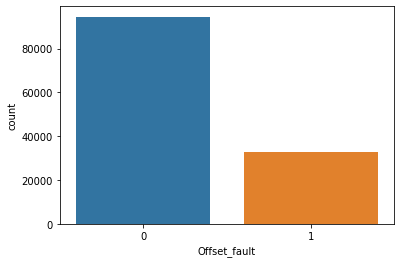

In [37]:
sns.countplot(sub.Offset_fault)